In [1]:
import gcsfs
import dask.array as da
import numpy as np
import pandas as pd
import allel
import zarr

In [2]:
import sys

In [3]:
sys.path.insert(0, "../../agam-report-base/src/python")
import hapclust

/opt/conda/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/jovyan/github/malariagen/vector-ops/agam-report-base/src/python/hapclust_opt.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# kubernetes cluster setup
n_workers = 20
from dask_kubernetes import KubeCluster
cluster = KubeCluster()

cluster.scale_up(n_workers)
# cluster.adapt(minimum=0, maximum=n_workers)
cluster

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at: tcp://10.33.122.111:36461
distributed.scheduler - INFO -   dashboard at:                     :8787


distributed.scheduler - INFO - Register tcp://10.33.119.82:33419
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.119.82:33419
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.17.14:40075
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.17.14:40075
distributed.core - INFO - Starting established connection


In [6]:
# dask client setup
from dask.distributed import Client, progress
client = Client(cluster)
client

distributed.scheduler - INFO - Receive client connection: Client-a16055b4-5a39-11eb-827b-32c03b80f573
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.33.122.111:36461 Dashboard: /user/alimanfoo@googlemail.com/proxy/8787/status,Cluster Workers: 2 Cores: 2 Memory: 24.00 GB


## Overview

xref https://github.com/malariagen/pipelines/issues/73

In [7]:
# create a GCSFileSystem just for the purpose of authentication
gcs_orig = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='cache', cache_timeout=0)

# create another one with those credentials
gcs =  gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token=gcs_orig.session.credentials, cache_timeout=0)

In [8]:
def h12_wrap(block):
    v = allel.garud_h(block)
    return np.array(v).reshape((1, -1))    

In [9]:
class HaplotypeCohort():
    
    def __init__(self, chromosomes, f, n):
        
        self.chromosomes = chromosomes
        self.name = n
        self.haplotypes = {}
        self.positions = {}
        
        for c in chromosomes:
            hap, pos = f(c)
            self.haplotypes[c] = hap
            self.positions[c] = pos
            
            print(c, hap.shape, pos.shape)
      #      print(c)

    def compute_hstats(self, snp_window_size=300):
        self.window_positions = {}
        self.hstats = {}
        
        for c in self.chromosomes:
            
            h = self.haplotypes[c].rechunk((snp_window_size, self.haplotypes[c].shape[1]))
            
            x = da.map_blocks(h12_wrap, h, chunks=(1, 4))

            self.window_positions[c] = allel.moving_statistic(self.positions[c], np.median, size=snp_window_size)        
            self.hstats[c] = x.compute()
            
    def cluster_haplotypes(self, chrom, start, stop, **kwargs):
        
        loc = self.positions[chrom].locate_range(start, stop)
        hclus = self.haplotypes[chrom][loc]
        print(hclus.shape)
        hapclust.fig_haplotypes_clustered(hclus, **kwargs)

In [10]:
def load_phase2_haplotypes(seq_id, country_name="Burkina Faso"):
    
    phase2_hap_path = "ag1000g-release/phase2.AR1/haplotypes/main/zarr/ag1000g.phase2.ar1.haplotypes"
    metadata_path = "ag1000g-release/phase2.AR1/haplotypes/haplotypes.autosomes.meta.txt"

    with gcs.open(metadata_path) as fh:
        hap_meta = pd.read_csv(fh, index_col=0, sep="\t")
        
     # need to open as mapping if this on cloud
    storez = gcs.get_mapper(phase2_hap_path)
    calldata = zarr.Group(storez)
    
    sel = hap_meta.country == country_name

    h = allel.GenotypeDaskArray(calldata[f"{seq_id}/calldata/GT"]).to_haplotypes().compress(sel, axis=1)
    
    # exclude invariant sites: rough attempt at making 2 datasets more equivalent.
    ac = h.count_alleles().compute()
    loc = ac.is_variant()
    h = h.compress(loc, axis=0)
    
    pos = allel.SortedIndex(np.compress(loc, calldata[f"{seq_id}/variants/POS"], axis=0))
    
    print("phase2", h.shape)

    return h, pos

In [11]:
def load_validation_phasing(seq_id):
    
    z_path = "vo_agam_production/phasing-validation/phasing-validation-zarr"
    zstore = gcs.get_mapper(z_path)

    zh = zarr.Group(zstore)

    h = allel.GenotypeDaskArray(zh[f"{seq_id}/calldata/GT"]).to_haplotypes()
    
    # exclude invariant sites: rough attempt at making 2 datasets more equivalent.
    ac = h.count_alleles().compute()

    loc = ac.is_variant()
    ac = h.count_alleles().compute()
    h = h.compress(ac.is_variant(), axis=0)
    pos = allel.SortedIndex(np.compress(loc, zh[f"{seq_id}/variants/POS"], axis=0))
    
    print(h.shape)
    
    return h, pos

In [12]:
hphase2 = HaplotypeCohort(["2R", "3R"], load_phase2_haplotypes, "phase2")
hphase2.compute_hstats()

phase2 (6259206, 334)
2R (6259206, 334) (6259206,)
phase2 (5372939, 334)
3R (5372939, 334) (5372939,)


distributed.core - INFO - Event loop was unresponsive in Scheduler for 46.76s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.scheduler - INFO - Register tcp://10.32.77.2:42027
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.77.2:42027
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.78.2:43381
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.78.2:43381
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.79.2:45351
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.79.2:45351
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.90.2:37677
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.90.2:37677
distributed.core -

In [13]:
hpipeline = HaplotypeCohort(["2R", "3R"], load_validation_phasing, "dev")
hpipeline.compute_hstats()

distributed.scheduler - INFO - Remove worker tcp://10.32.84.2:34541
distributed.core - INFO - Removing comms to tcp://10.32.84.2:34541
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


(4635308, 334)
2R (4635308, 334) (4635308,)
(3958025, 334)
3R (3958025, 334) (3958025,)


distributed.core - INFO - Event loop was unresponsive in Scheduler for 34.86s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.core - INFO - Event loop was unresponsive in Scheduler for 5.08s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.core - INFO - Event loop was unresponsive in Scheduler for 31.37s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


## Plot H12

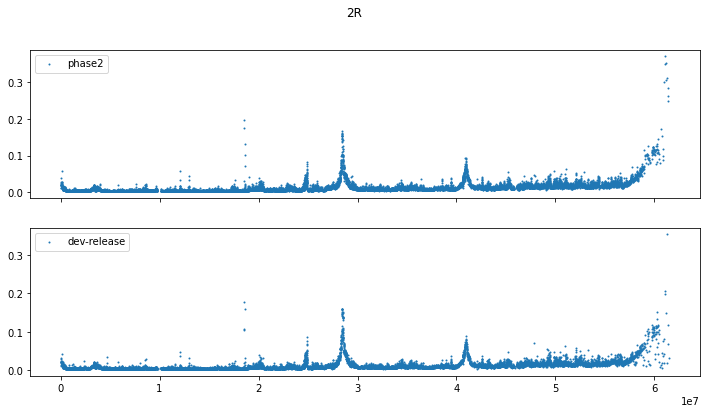

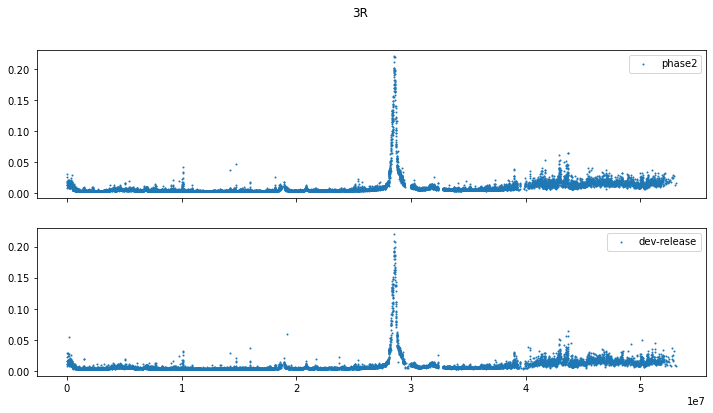

In [14]:
for chrom in hphase2.chromosomes:

    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(12, 6))
    ax1, ax2 = axes

    ax1.scatter(hphase2.window_positions[chrom], hphase2.hstats[chrom][:-1, 1], s=1, label="phase2")
    ax1.legend()
    ax2.scatter(hpipeline.window_positions[chrom], hpipeline.hstats[chrom][:-1, 1], s=1, label="dev-release")
    ax2.legend()
    
#     ax1.plot(hphase2.hstats[chrom][:-1, 1], label)
#     ax2.plot(hpipeline.hstats[chrom][:-1, 1])
      
    fig.suptitle(chrom)

# Find high values and cluster haplotypes

In [15]:
high_v = hphase2.hstats["3R"][:-1, 1] > 0.2

list(np.compress(high_v, hphase2.window_positions["3R"]))

[28521199.5, 28527971.5, 28536603.0, 28558723.5, 28562694.0, 28569912.0]

In [16]:
high_v = hpipeline.hstats["3R"][:-1, 1] > 0.2

list(np.compress(high_v, hpipeline.window_positions["3R"]))

[28537802.5, 28559181.5, 28568805.0, 28611414.0]

(6429, 334)


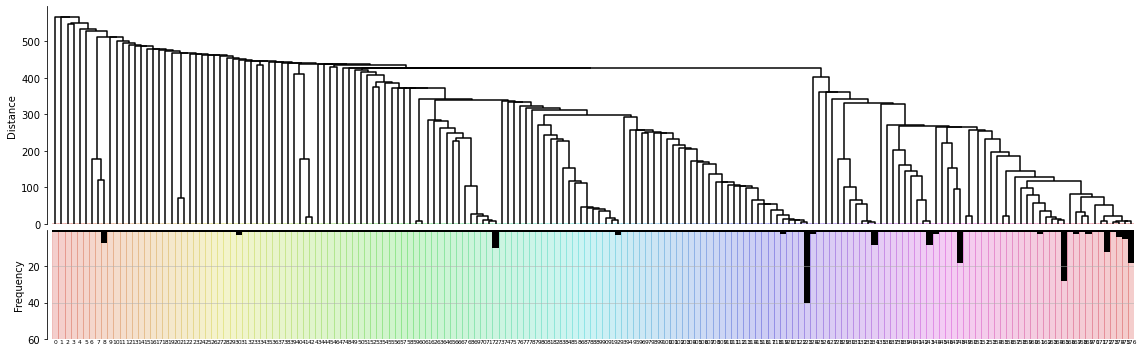

In [17]:
hphase2.cluster_haplotypes("3R", 28_500_000, 28_600_000, fig=plt.figure(figsize=(16, 5)), truncate_distance=5)

(5117, 334)


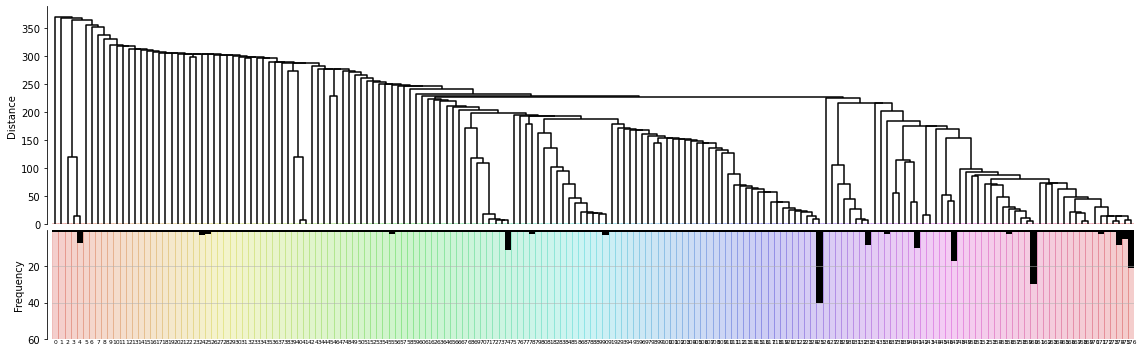

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [18]:
hpipeline.cluster_haplotypes("3R", 28_500_000, 28_600_000, fig=plt.figure(figsize=(16, 5)), truncate_distance=5)

(5647, 334)


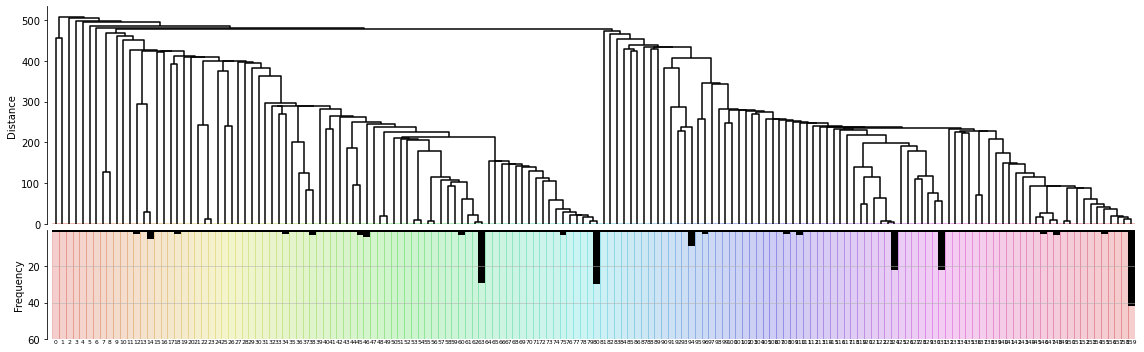

In [21]:
hphase2.cluster_haplotypes("2R", 28_450_000, 28_550_000, fig=plt.figure(figsize=(16, 5)), truncate_distance=5)

(6801, 334)


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


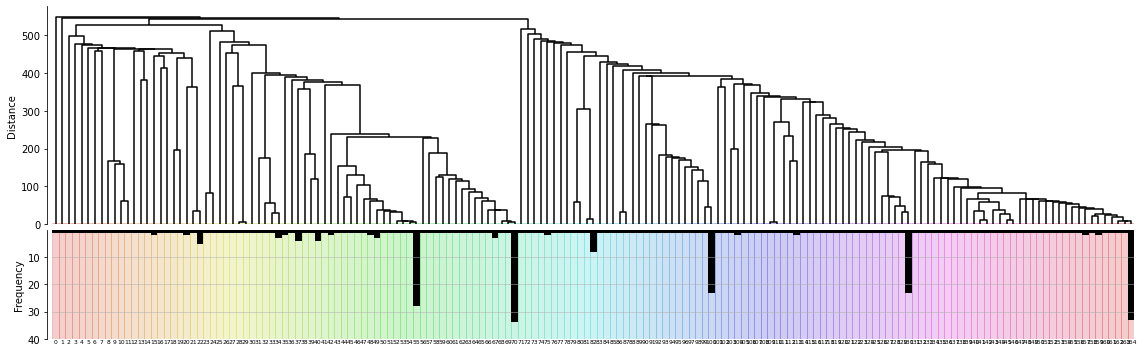

In [22]:
hpipeline.cluster_haplotypes("2R", 28_450_000, 28_550_000, fig=plt.figure(figsize=(16, 5)), truncate_distance=5)